# Ghost Vs No Ghost ~ all frequencies: LL10

In [1]:
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns
import scipy
import joblib

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra



In [2]:
## Prep paths ##

subject = 'LL10'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [3]:
## Load Neural Data

# load
last_away_ecpohs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_away_events.fif")

# get good epochs (for behavioral data only)
good_epochs = [i for i,x in enumerate(last_away_ecpohs.get_annotations_per_epoch()) if not x]
bad_epochs = [i for i,x in enumerate(last_away_ecpohs.get_annotations_per_epoch()) if  x]

# onlt good epochs
last_away_ecpohs = last_away_ecpohs[good_epochs]

# load behavioral data
last_away_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_last_away_events.csv")

## Prep Behavioral Data
last_away_data['trial_numeric'] = last_away_data['trial_numeric'] - 1
last_away_data = last_away_data[last_away_data.index.isin(good_epochs)]

# set info as metadata
last_away_ecpohs.metadata = last_away_data

Reading /home/brooke/pacman/preprocessing/LL10/ieeg/LL10_bp_raw_clean_last_away_events.fif ...
    Found the data of interest:
        t =   -5000.00 ...    5000.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_21786/870373520.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/LL10/ieeg/LL10_bp_raw_clean_last_away_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  last_away_ecpohs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_away_events.fif")


0 bad epochs dropped
Not setting metadata
225 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 5 columns


In [4]:
# separate ghost and no ghost trials

ghost_epochs = last_away_ecpohs["TrialType <= 16"]
no_ghost_epochs = last_away_ecpohs["TrialType > 16"]

In [5]:
## Dictionary of electrode locations ##


ROIs = {
    'hc'     :['RH1', 'RH2', 'RHP1', 'RHP2', 'LH1', 'LH2'],
    'ofc'    :['ROF1'],
    'amyg'   :['RA1', 'RA2'],
    'insula' :[],
    'cing'   :['RAC1', 'RAC2', 'LOF1', 'LOF2', 'LAC1', 'LAC2']
}

hc_list = []
hc_indices = []
hc_names = []
ofc_list = []
ofc_indices = []
ofc_names = []
amyg_list = []
amyg_names = []               
insula_list = []
insula_names = []            
cing_list = []
cing_names = []               
pairs_long_name = [ch.split('-') for ch in last_away_ecpohs.info['ch_names']]
bidx = len(last_away_ecpohs.info['bads']) +1
pairs_name = pairs_long_name[bidx:len(pairs_long_name)]

for ix in range(0, len(pairs_name)):
    if pairs_name[ix][0] in ROIs['hc'] or pairs_name[ix][1] in ROIs['hc']:
        hc_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])
        hc_names.append(pairs_name[ix])
        hc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ofc'] or pairs_name[ix][1] in ROIs['ofc']:
        ofc_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])
        ofc_names.append(pairs_name[ix])
        ofc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['amyg'] or pairs_name[ix][1] in ROIs['amyg']:
        amyg_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])       
        amyg_names.append(pairs_name[ix])
    if pairs_name[ix][0] in ROIs['insula'] or pairs_name[ix][1] in ROIs['insula']:
        insula_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])       
        insula_names.append(pairs_name[ix])
    if pairs_name[ix][0] in ROIs['cing'] or pairs_name[ix][1] in ROIs['cing']:
        cing_list.append(last_away_ecpohs.info['ch_names'][ix + bidx])       
        cing_names.append(pairs_name[ix])
        


In [6]:
def MM_compute_TFR(epochs, freqs, n_cycles, baseline, zscore=True, time_bandwidth=None):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_morlet(epochs,freqs,n_cycles,return_itc=False,
                                            average=False,  n_jobs = 8)
    print('log transforming')
    TFR.data = np.log(TFR.data)
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,:,bix].mean(axis=(3),keepdims=True)
        bstd = TFR.data[:,:,:,bix].std(axis=(3),keepdims=True)
        TFR.data = (TFR.data - bmean) / bstd
    return TFR

def MM_compute_TFR_ratio(epochs, freqs, n_cycles, baseline, zscore=True, time_bandwidth=None):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_morlet(epochs,freqs,n_cycles,return_itc=False,
                                            average=False,  n_jobs = 8)
    print('log transforming')
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,:,bix].mean(axis=(0,3),keepdims=True)
        TFR.data = TFR.data/bmean

    return TFR

def MM_compute_TFR_logratio(epochs, freqs, n_cycles, baseline, zscore=True, time_bandwidth=None):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_morlet(epochs,freqs,n_cycles,return_itc=False,
                                            average=False,  n_jobs = 8)
    print('log transforming')
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,:,bix].mean(axis=(0,3),keepdims=True)
        TFR.data = TFR.data/bmean
        TFR.data = np.log(TFR.data) 
                                            
    return TFR

def MM_compute_TFR_zlogratio(epochs, freqs, n_cycles, baseline, zscore=True, time_bandwidth=None):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_morlet(epochs,freqs,n_cycles,return_itc=False,
                                            average=False,  n_jobs = 8)
    print('log transforming')
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,:,bix].mean(axis=(0,3),keepdims=True)
        TFR.data = TFR.data/bmean
        TFR.data = np.log(TFR.data) 
        bstd = TFR.data[:,:,:,bix].std(axis=(0,3),keepdims=True)
        TFR.data = TFR.data/ bstd
    return TFR


def stockwell_TFR_ratio(epochs, fmin, fmax, baseline, zscore=True):
    print('computing TFR')
    TFR = mne.time_frequency.tfr_stockwell(epochs,fmin,fmax,return_itc=False,
                                            n_jobs = 8)
    print('log transforming')
    if zscore:
        print('z-scoring to baseline')
        bix = [a and b  for a, b in zip(TFR.times >= baseline[0], TFR.times <= baseline[1])]
        bmean = TFR.data[:,:,bix].mean(axis=(0,3),keepdims=True)
        TFR.data = TFR.data/bmean

    return TFR

In [7]:
# Set frequencies

freqs = np.logspace(start = np.log10(1), stop = np.log10(150), num = 80, base = 10, endpoint = True)
n_cycles = np.logspace(np.log10(2), np.log10(30), base = 10, num = 80)

# formulas to check bandwidth and time bin
band_width = (freqs / n_cycles) * 2
time_bin = n_cycles / freqs / np.pi
print(freqs)
print(n_cycles)
print(time_bin)
print(band_width)


[  1.           1.06548039   1.13524845   1.20958496   1.28878905
   1.37317945   1.46309577   1.55889984   1.6609772    1.76973863
   1.8856218    2.00909304   2.14064922   2.28081976   2.43016872
   2.5892971    2.75884527   2.93949552   3.13197482   3.33705774
   3.55556956   3.78838962   4.03645484   4.30076345   4.5823791
   4.88243505   5.20213877   5.54277682   5.90571998   6.2924288
   6.70445946   7.14347005   7.61122722   8.10961331   8.64063391
   9.20642595   9.80926626  10.45158079  11.13595433  11.8651409
  12.6420749   13.46988283  14.35189595  15.29166362  16.29296764
  17.35983743  18.49656627  19.70772855  20.99819821  22.37316831
  23.83817199  25.39910467  27.06224782  28.83429423  30.72237491
  32.73408785  34.87752853  37.16132253  39.59466023  42.18733383
  44.94977669  47.89310538  51.02916436  54.37057369  57.93077979
  61.72410955  65.76582801  70.07219975  74.66055437  79.54935622
  84.75827869  90.30828341  96.22170458 102.52233885 109.23554107
 116.38832636

### Hippocampus

In [7]:
hc_list

['RH1-RH2', 'RH2-RH3', 'RHP2-RHP3', 'LH1-LH2', 'LH2-LH3']

In [8]:
ghost_hc = ghost_epochs.copy().pick_channels(hc_list)
no_ghost_hc = no_ghost_epochs.copy().pick_channels(hc_list)

In [9]:
ghost_hc= ghost_hc.resample(1000)
no_ghost_hc= no_ghost_hc.resample(1000)

In [10]:
ghost_hc.metadata

trial_numeric  TrialType  sample  sample_before  event
0                1          3   23270              0      1
1                2          8   27084              0      1
2                3         11   29952              0      1
3                5         16   36531              0      1
6                9          9   62003              0      1
..             ...        ...     ...            ...    ...
219            233          6  843955              0      1
220            234          8  846643              0      1
221            235         10  849228              0      1
222            236         15  852096              0      1
224            238         16  862208              0      1

[167 rows x 5 columns]

In [11]:
# random_trials = np.random.randint(low = 0, high = 143, size = 40 )
# ghost_hc_test = ghost_hc['trial_numeric.sample(40)']
# ghost_hc_test


In [13]:


# ghost_TFR = stockwell_TFR_ratio(ghost_hc,fmin = .5,fmax = 150,baseline = (-2,2), zscore=True)
# no_ghost_TFR = stockwell_TFR_ratio(no_ghost_hc,fmin = .5,fmax = 150,baseline = (-2,2), zscore=True)

ghost_TFR = MM_compute_TFR(ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)
no_ghost_TFR = MM_compute_TFR(no_ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)

computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   55.1s remaining:  1.4min
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   59.3s finished


Adding metadata with 5 columns
log transforming
z-scoring to baseline
computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   13.6s remaining:   20.4s


Adding metadata with 5 columns


[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   14.7s finished


log transforming
z-scoring to baseline


In [14]:
ghost_TFR.crop(tmin = -2, tmax = 2)
no_ghost_TFR.crop(tmin = -2, tmax = 2)

<EpochsTFR | time : [-2.000000, 2.000000], freq : [1.000000, 150.000000], epochs : 41, channels : 5, ~500.6 MB>

In [15]:
ghost_TFR.data.shape

(167, 5, 80, 4001)

/tmp/ipykernel_107406/2013443007.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_107406/2013443007.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


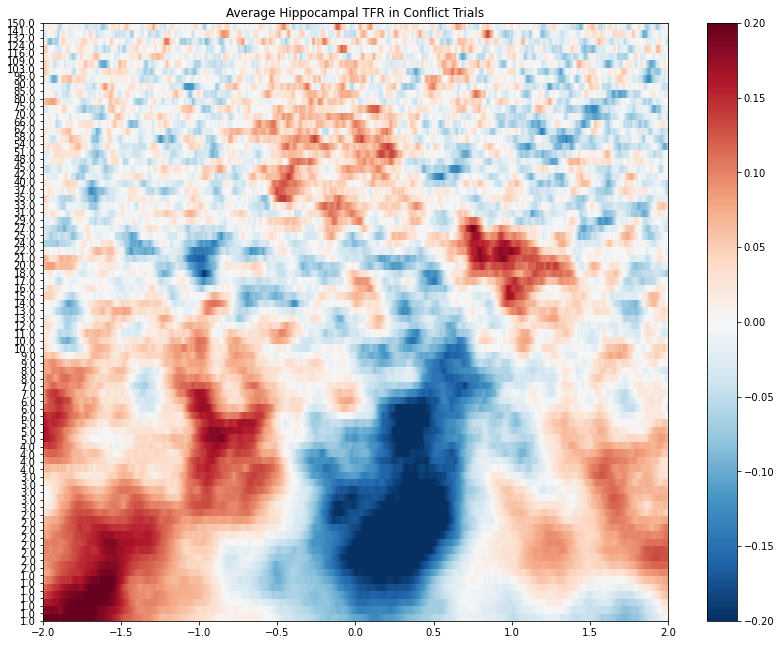

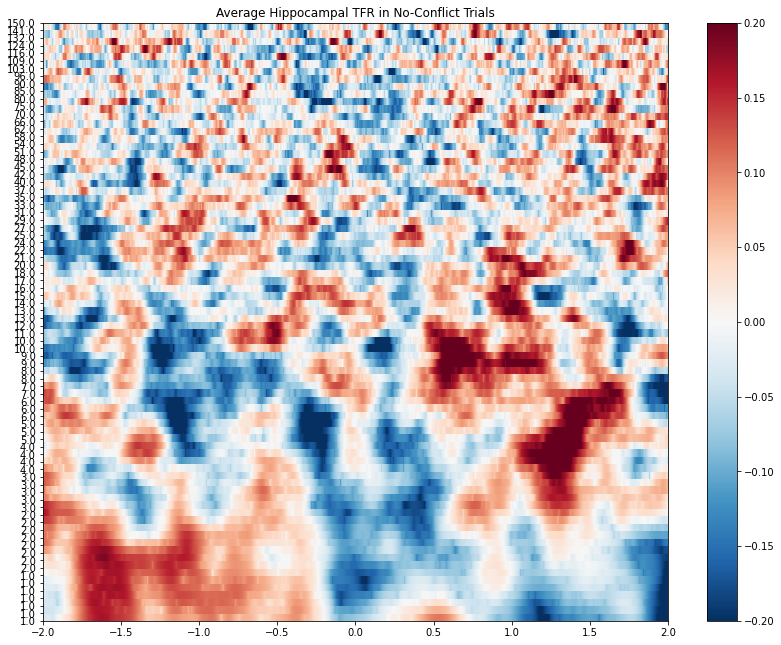

In [16]:
plt.rcParams['figure.figsize'] = [14, 11]
fig, ax = plt.subplots()
i = ax.imshow(ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Hippocampal TFR in Conflict Trials")
fig.show()
fig.savefig('LL10_average_hippocampus_conflict.png', dpi=600)

fig, ax = plt.subplots()
i = ax.imshow(no_ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Hippocampal TFR in No-Conflict Trials")
fig.show()
fig.savefig('LL10_average_hippocampus_noconflict.png', dpi=600)



In [17]:
# loop over channels and save csvs
fidx = np.where((freqs > 3) & (freqs < 8))[0]

# Ghost Trials
for chix in range(len(ghost_TFR.ch_names)):

    trial_theta_power = ghost_TFR.data[:, chix, fidx, :].mean(axis = 1)
    channel_df = pd.DataFrame(trial_theta_power[:, ::50])
    channel_df['trial'] = ghost_hc.metadata.trial_numeric.to_numpy(copy = True)
        
    channel_df.to_csv(f"{preproc_data_dir}/theta_csvs/{ghost_TFR.ch_names[chix]}_hc_trial_theta_choice_locked_ghost.csv")
    
    

# No Ghost Trials
for chix in range(len(no_ghost_TFR.ch_names)):

    trial_theta_power = no_ghost_TFR.data[:, chix, fidx, :].mean(axis = 1)
    channel_df = pd.DataFrame(trial_theta_power[:, ::50])
    channel_df['trial'] = no_ghost_hc.metadata.trial_numeric.to_numpy(copy = True)
        
    channel_df.to_csv(f"{preproc_data_dir}/theta_csvs/{no_ghost_TFR.ch_names[chix]}_hc_trial_theta_choice_locked_noghost.csv")   

In [18]:
channel_df

0         1         2         3         4         5         6  \
0  -0.882272 -0.860424 -0.639482 -0.275896 -0.120267 -0.131932  0.140796   
1   0.585148  0.092099 -0.430720 -0.497560 -0.436108 -0.194143  0.013542   
2  -0.920733 -0.185509  0.145881  0.272936  0.224900  0.041719 -0.259056   
3   0.131651  0.520529  0.671797  0.615294  0.395089  0.068184 -0.188089   
4  -0.467839 -0.808158 -0.791945 -0.569380 -0.020323  0.385856  0.667899   
5  -0.426763 -0.286324 -0.326302  0.093964  0.345652  0.394796  0.244822   
6   0.792923  0.437170 -0.148650 -0.234991  0.054175  0.307654  0.377320   
7   0.155632  0.033809 -0.290916 -0.130092 -0.065325 -0.263074 -0.079139   
8   0.770311  0.792387  0.634678  0.579509  0.584957  0.420929  0.110927   
9  -0.580600 -0.445979 -0.556260 -0.436029 -0.207438 -0.170844 -0.307117   
10  0.298300  0.481880  0.448502  0.175229 -0.356099 -0.757177 -0.869652   
11 -1.073412 -1.441843 -1.009185 -0.773640 -0.736546 -0.426716 -0.204008   
12  0.207658  0.420325  0.416134  0.221332  0.379438  0.234506 -0.155353   
13  0.130542  0.375659  0.420766  0.430011  0.559360  0.496692  0.337215   
14 -0.821145 -0.758006 -0.276082  0.030049  0.224648  0.350647  0.350526   
15 -1.143223 -0.626226 -0.361962  0.138497  0.620116  0.907083  1.026784   
16 -0.433931 -0.548046 -0.421940  0.001656  0.227724  0.242037  0.035041   
17  0.000645 -0.013896 -0.187822 -0.535488 -0.900184 -0.556185  0.008612   
18 -0.327691 -0.379522 -0.391267 -0.139598 -0.098810 -0.256135 -0.086030   
19 -0.002963  0.161516  0.159598 -0.010441 -0.356279 -0.878636 -1.340964   
20 -0.183787 -0.160586  0.114620  0.142030 -0.073225 -0.440721 -0.192436   
21  0.536129  0.440010  0.158430 -0.251526 -0.142200 -0.261186 -0.588590   
22 -0.109474  0.134725  0.156452 -0.010823 -0.370330 -0.929348 -1.282850   
23  0.153183  0.027091 -0.389360 -0.934472 -0.735450 -0.417459 -0.360847   
24  0.039915  0.208392  0.214464  0.079912 -0.156363 -0.469085 -0.819073   
25 -0.589773 -0.317435 -0.239842 -0.038608  0.434131  0.705024  0.760612   
26  0.720482  0.693106  0.509884  0.167238 -0.134845 -0.076113  0.334379   
27 -0.519656 -1.131446 -0.641848 -0.111786  0.295330  0.530053  0.578945   
28 -0.778209 -1.008550 -1.245636 -0.897290 -0.755808 -0.819518 -0.497202   
29 -0.682044 -0.631982 -0.522086 -0.215290 -0.144193 -0.299257 -0.672711   
30  0.123489 -0.163351 -0.655267 -0.966502 -1.305428 -1.828325 -1.774665   
31  0.470671  0.010562  0.108023  0.012796 -0.273610 -0.675216 -0.386882   
32 -0.424515 -0.641985 -1.011440 -1.513177 -1.674375 -1.384981 -0.880359   
33 -0.128906  0.106299  0.143677 -0.028161 -0.178584 -0.217125 -0.478068   
34  0.613029  0.573285  0.417946  0.165366 -0.177484 -0.602474 -0.827776   
35 -0.047842 -0.349535 -0.680740 -0.490242 -0.443415  0.079615  0.348106   
36  0.178152  0.246081  0.249738  0.170404 -0.022394 -0.343081 -0.831485   
37  0.698725  0.873478  0.931747  0.968333  0.975100  0.860179  0.581202   
38  0.384622 -0.064141 -0.035325 -0.024161  0.294985  0.623338  0.768892   
39 -0.032185 -0.775022 -0.971057 -0.811706 -0.122340  0.412618  0.765501   
40  0.160398 -0.313854 -0.982057 -1.310958 -0.825836 -0.540341 -0.429802   

           7         8         9  ...        72        73        74        75  \
0   0.458491  0.631879  0.655252  ...  1.265190  1.228452  1.067783  0.775353   
1   0.117179  0.031400 -0.266501  ...  0.332147 -0.020504 -0.311807 -0.205613   
2  -0.696110 -0.538867  0.033876  ... -0.234828 -0.506747 -0.602837 -0.537883   
3   0.051022  0.169297  0.195410  ...  0.073610  0.136616  0.083112 -0.109608   
4   0.841757  0.884208  0.768827  ... -0.329213  0.012816  0.472426  0.762379   
5  -0.067712  0.346856  0.754902  ... -0.196746 -0.599743 -0.808053 -0.830099   
6   0.302864  0.098426  0.097347  ...  0.906304  0.807810  0.568464  0.210013   
7   0.026978  0.579601  0.978867  ... -0.172662 -0.006734 -0.000743 -0.144434   
8  -0.035437  0.318852  0.548481  ... -0.118653 -0.268839  0.054670  0.165218   
9  -0.53

In [17]:
# true difference matrix
true_diff_matrix = ghost_TFR.data[:, :, :, :].mean(axis = 0).mean(axis = 0) - no_ghost_TFR.data[:, :, :, :].mean(axis = 0).mean(axis = 0)


# initialize permuted matrix
permuted_matrix = np.nan * np.ones_like(true_diff_matrix)
permuted_matrices = np.repeat(permuted_matrix[np.newaxis,...], 1000, axis=0)

# get incex vectors
num_ghost_trials = ghost_TFR.data.shape[0]
num_no_ghost_trials = no_ghost_TFR.data.shape[0]
total_trials = num_ghost_trials + num_no_ghost_trials
trial_indices = np.arange(0, total_trials, 1)

# combine all tfrs
all_tfrs = np.concatenate([ghost_TFR.data[:, :, :, :] , no_ghost_TFR.data[:, :, :, :]], axis = 0)

for permute in range(0, 1000):
    
    trial_indices = np.arange(0, total_trials, 1)
    np.random.seed(permute)
    fake_ghost_indices = np.random.choice(a = trial_indices, size=num_ghost_trials, replace = False)
    fake_no_ghost_indicies = np.delete(trial_indices, fake_ghost_indices)


    fake_ghost_tfr = all_tfrs[fake_ghost_indices, :, :, :]
    fake_no_ghost_tfr = all_tfrs[fake_no_ghost_indicies, :, :, :]

    permuted_matrices[permute, :, :] = fake_ghost_tfr.mean(axis = 0).mean(axis = 0) - fake_no_ghost_tfr.mean(axis = 0).mean(axis = 0)


In [18]:
# create dummy sig matrix
sig_matrix = np.full(true_diff_matrix.shape, False, dtype = 'bool')
pval_matrix = np.nan * np.ones_like(true_diff_matrix)


# find values at the extreme
for y in range(0,80):
    for x in range(0, 4001):

        permuted_dist = np.sort(permuted_matrices[:, y, x])

        if true_diff_matrix[y, x] <= permuted_dist[50] or true_diff_matrix[y, x] >=permuted_dist[950] :
            sig_matrix[y, x] = True
        else:
            sig_matrix[y, x] = False

sig_diff_matrix = np.where(sig_matrix, true_diff_matrix, np.nan)


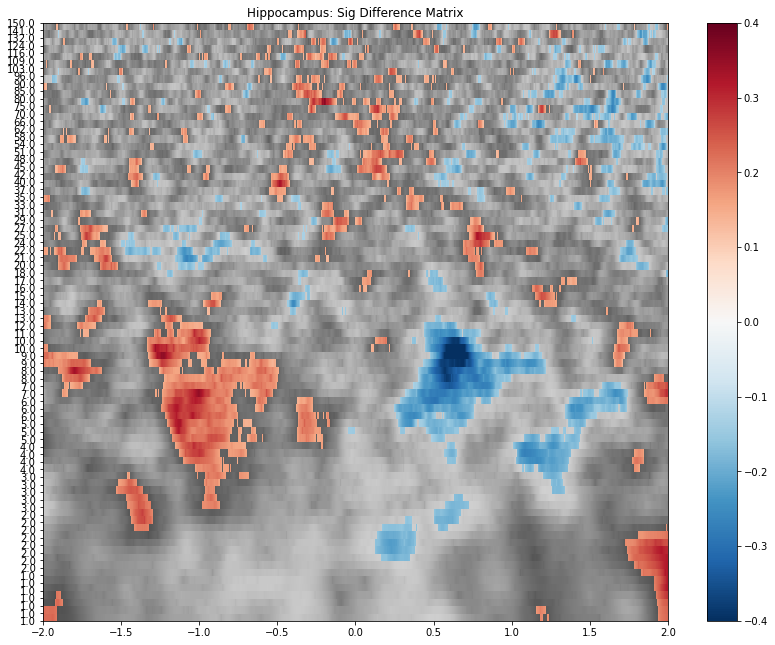

In [19]:

fig, ax = plt.subplots()
i1 = ax.imshow(true_diff_matrix, cmap = 'Greys', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
i2 = ax.imshow(sig_diff_matrix, cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i2)
ax.set_title("Hippocampus: Sig Difference Matrix")
fig.show()



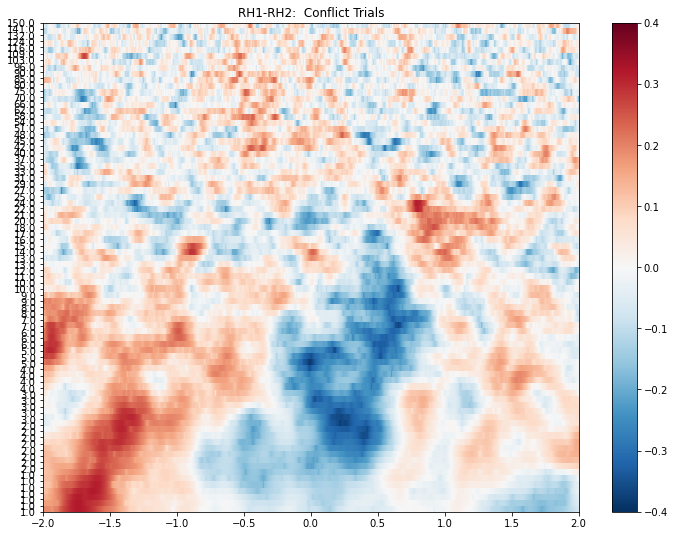

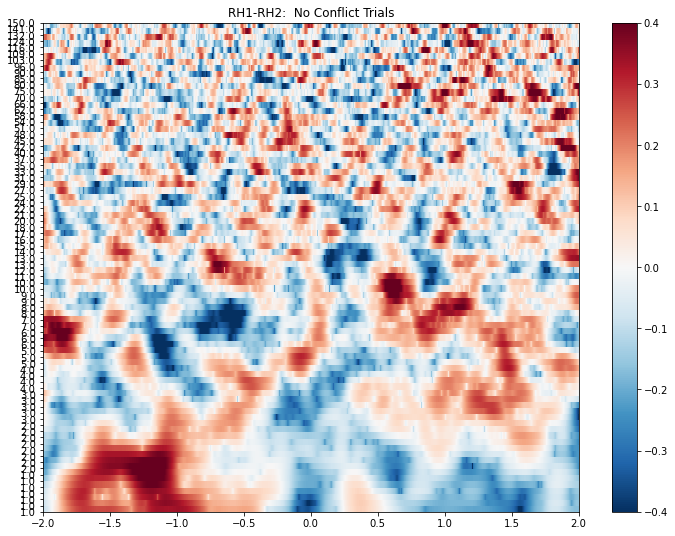

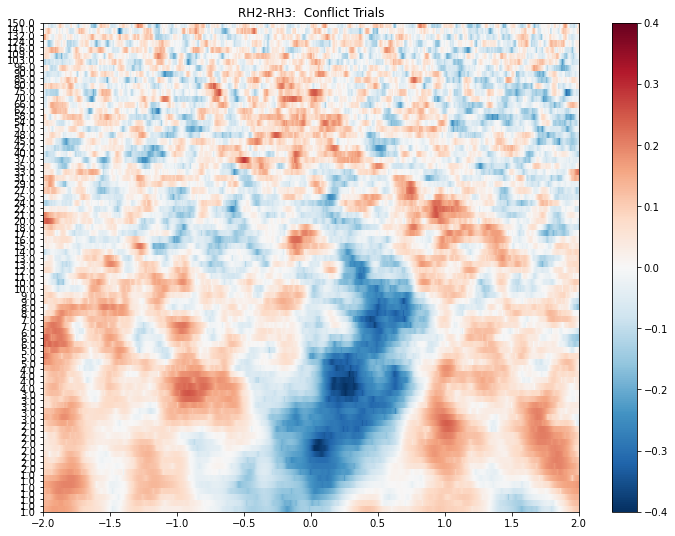

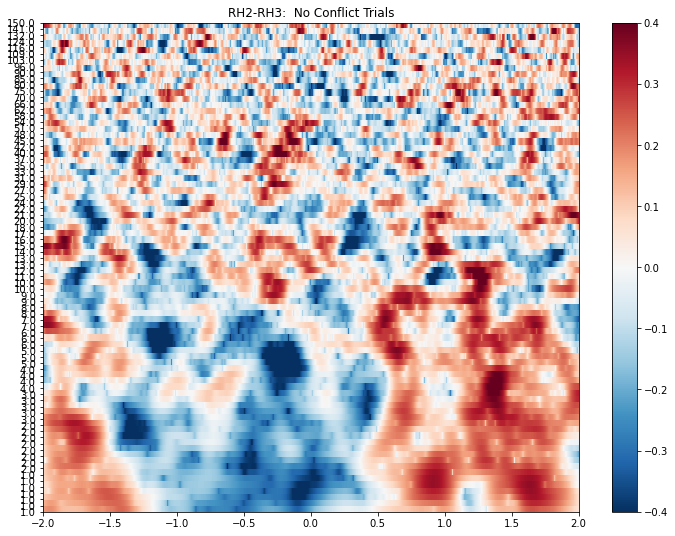

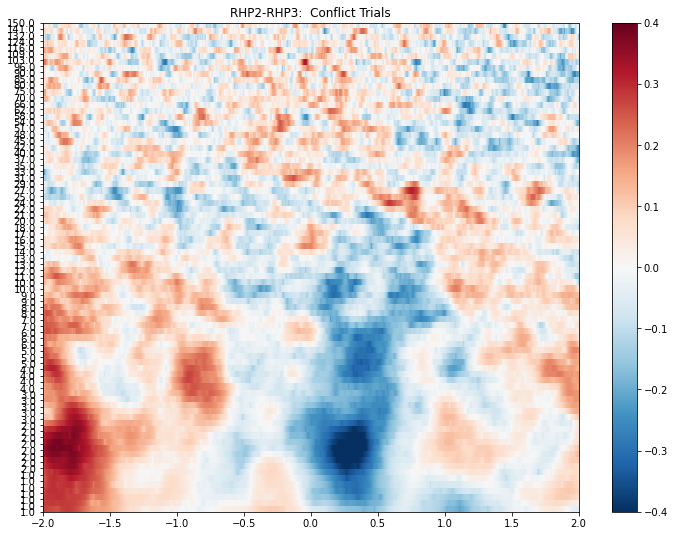

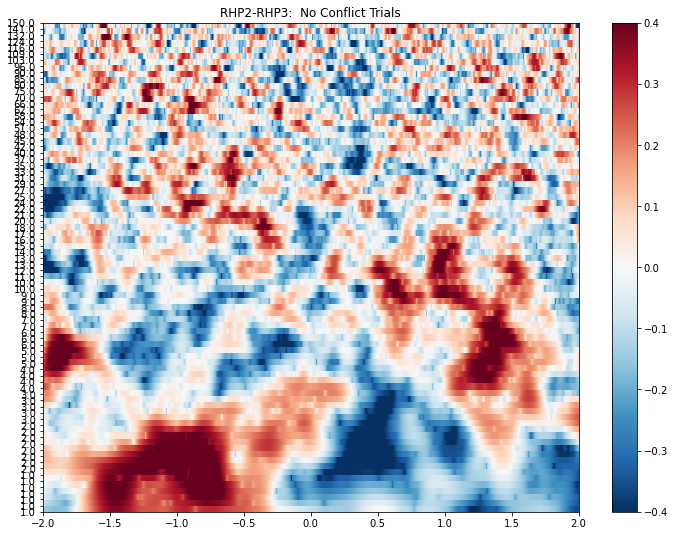

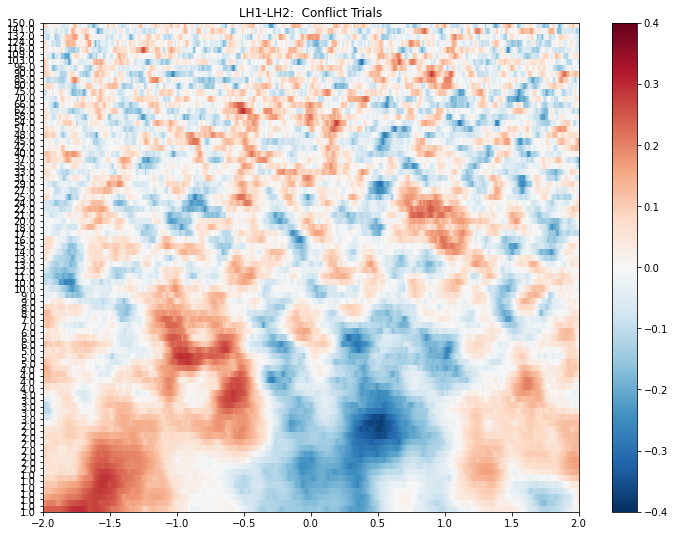

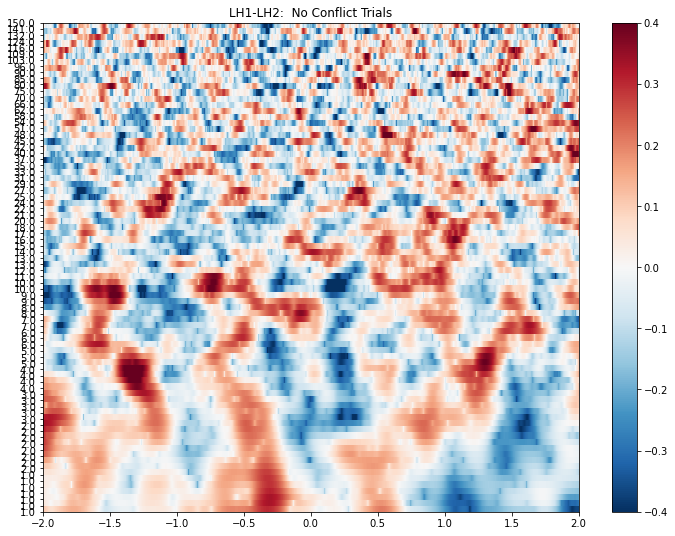

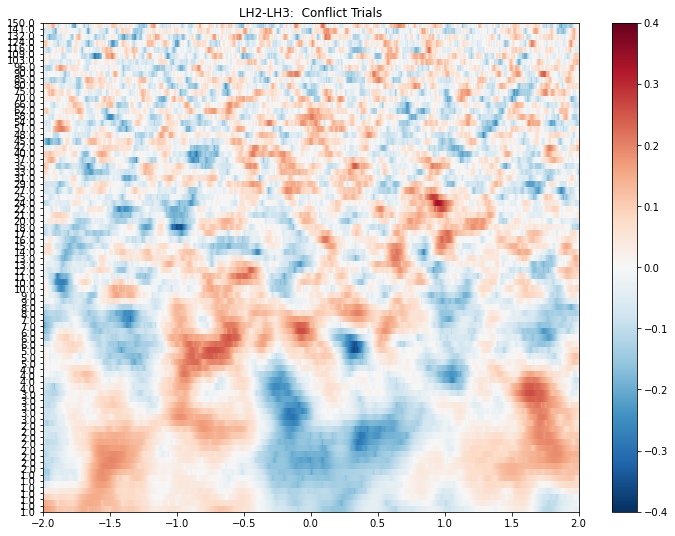

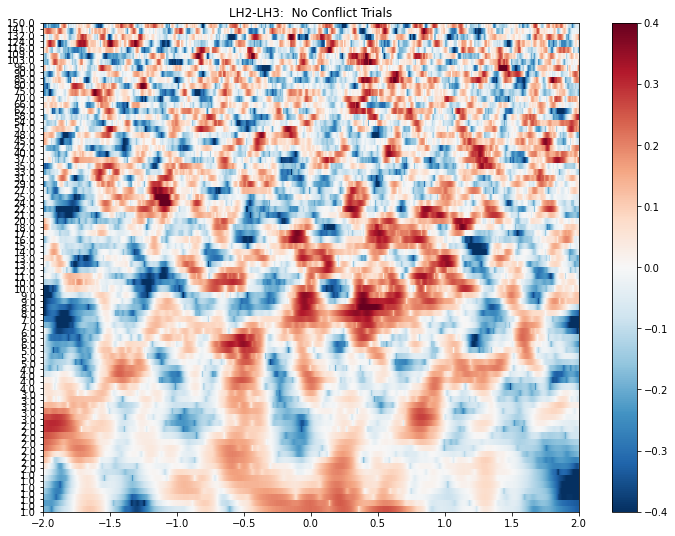

In [20]:
plt.rcParams['figure.figsize'] = [14, 11]

chix = 0
for ch in ghost_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Conflict Trials")
    fig.show()

    fig, ax = plt.subplots()
    i = ax.imshow(no_ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  No Conflict Trials")
    fig.show()
    
    chix = chix + 1

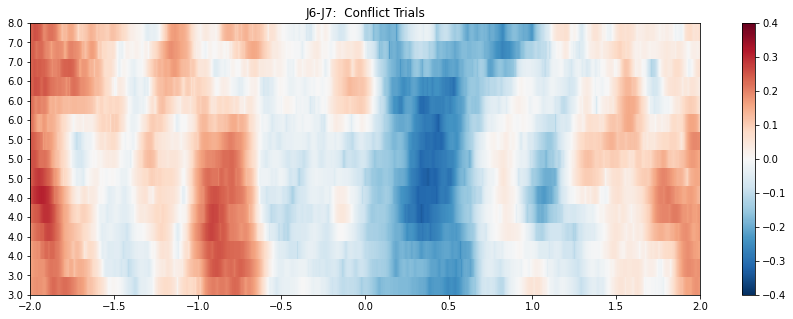

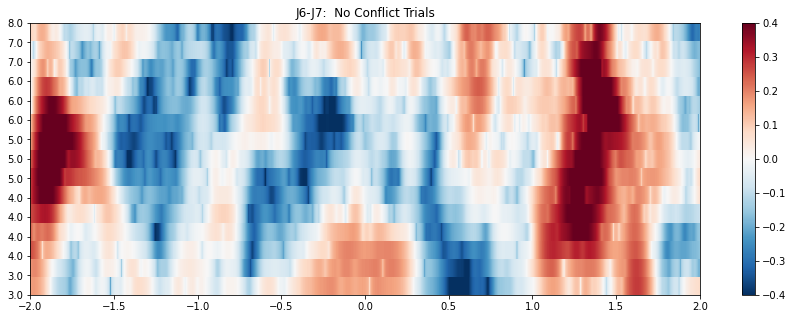

In [21]:
plt.rcParams['figure.figsize'] = [15, 5]

chix = 2
ch = 'J6-J7'
fidx = np.where((freqs > 3) & (freqs < 8))[0]
new_freqs = freqs[fidx]

fig, ax = plt.subplots()
i = ax.imshow(ghost_TFR.data[:, chix, fidx, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, new_freqs[0], new_freqs[-1]], vmin = -.4, vmax = .4)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs[fidx]),np.max(ghost_TFR.freqs[fidx]),len(ghost_TFR.freqs[fidx])))
ax.set_yticklabels(np.round(ghost_TFR.freqs[fidx]))
bar = plt.colorbar(i)
ax.set_title(f"{ch}:  Conflict Trials")
fig.show()

fig, ax = plt.subplots()
i = ax.imshow(no_ghost_TFR.data[:, chix, fidx, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, new_freqs[0], new_freqs[-1]], vmin = -.4, vmax = .4)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs[fidx]),np.max(ghost_TFR.freqs[fidx]),len(ghost_TFR.freqs[fidx])))
ax.set_yticklabels(np.round(ghost_TFR.freqs[fidx]))
bar = plt.colorbar(i)
ax.set_title(f"{ch}:  No Conflict Trials")
fig.show()


In [22]:
ghost_cis = []
no_ghost_cis = []
for theta_index in fidx:

    ghost_cis.append([1.96 * np.std(x)/np.sqrt(len(x)) for x in np.transpose(ghost_TFR.data[:, chix, theta_index, :])])
    no_ghost_cis.append([1.96 * np.std(x)/np.sqrt(len(x)) for x in np.transpose(no_ghost_TFR.data[:, chix, theta_index, :])])

ghost_ci = np.array(ghost_cis).mean(axis = 0)
no_ghost_ci = np.array(no_ghost_cis).mean(axis = 0)

In [23]:
np.transpose(no_ghost_TFR.data[:, chix, fidx, :].mean(axis = 1)).shape

(4001, 41)

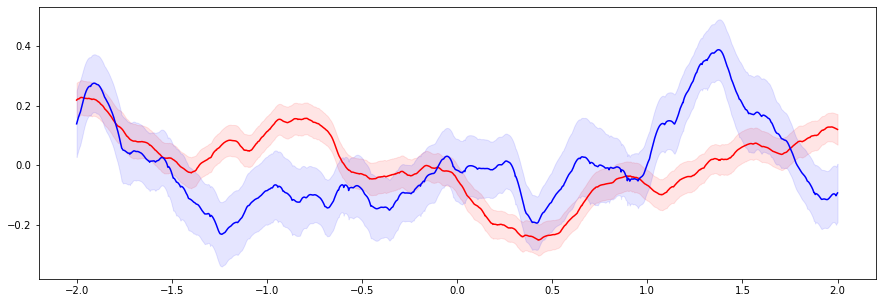

In [24]:
ghost_ci = [np.std(x)/np.sqrt(len(x)) for x in np.transpose(ghost_TFR.data[:, chix, fidx, :].mean(axis = 1))]
no_ghost_ci = [np.std(x)/np.sqrt(len(x)) for x in np.transpose(no_ghost_TFR.data[:, chix, fidx, :].mean(axis = 1))]

y_ghost = ghost_TFR.data[:, chix, fidx, :].mean(axis = 0).mean(axis = 0)
y_no_ghost = no_ghost_TFR.data[:, chix, fidx, :].mean(axis = 0).mean(axis = 0)

fig, ax = plt.subplots()
i = ax.plot(no_ghost_TFR.times, y_ghost, color = 'red')
ax.fill_between(no_ghost_TFR.times, (y_ghost-ghost_ci), (y_ghost + ghost_ci), color='red', alpha=.1)
i = ax.plot(no_ghost_TFR.times, y_no_ghost, color = 'blue')
ax.fill_between(no_ghost_TFR.times, (y_no_ghost-no_ghost_ci), (y_no_ghost + no_ghost_ci), color='blue', alpha=.1)

fig.show()


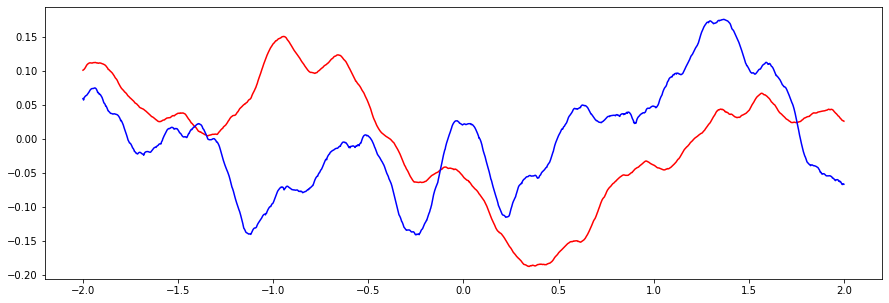

In [25]:
# ghost_ci = [1.96 * np.std(x)/np.sqrt(len(x)) for x in np.transpose(ghost_TFR.data[:, chix, fidx, :])]
# no_ghost_ci = [1.96 * np.std(x)/np.sqrt(len(x)) for x in np.transpose(no_ghost_TFR.data[:, chix, fidx, :])]

y_ghost = ghost_TFR.data[:, :, fidx, :].mean(axis = 0).mean(axis = 1).mean(axis = 0)
y_no_ghost = no_ghost_TFR.data[:, :, fidx, :].mean(axis = 0).mean(axis = 1).mean(axis = 0)

fig, ax = plt.subplots()
i = ax.plot(no_ghost_TFR.times, y_ghost, color = 'red')
i = ax.plot(no_ghost_TFR.times, y_no_ghost, color = 'blue')

fig.show()

### OFC

In [15]:
ghost_hc = ghost_epochs.copy().pick_channels(ofc_list)
no_ghost_hc = no_ghost_epochs.copy().pick_channels(ofc_list)

In [16]:
ghost_hc= ghost_hc.resample(1000)
no_ghost_hc= no_ghost_hc.resample(1000)

In [17]:
ghost_TFR = []
no_ghost_TFR = []

ghost_TFR = MM_compute_TFR(ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)
no_ghost_TFR = MM_compute_TFR(no_ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)

computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Adding metadata with 5 columns


[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   42.3s finished


log transforming
z-scoring to baseline
computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Adding metadata with 5 columns


[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   10.7s finished


log transforming
z-scoring to baseline


In [18]:
ghost_TFR.crop(tmin = -2, tmax = 2)
no_ghost_TFR.crop(tmin = -2, tmax = 2)

<EpochsTFR | time : [-2.000000, 2.000000], freq : [1.000000, 150.000000], epochs : 41, channels : 1, ~100.1 MB>

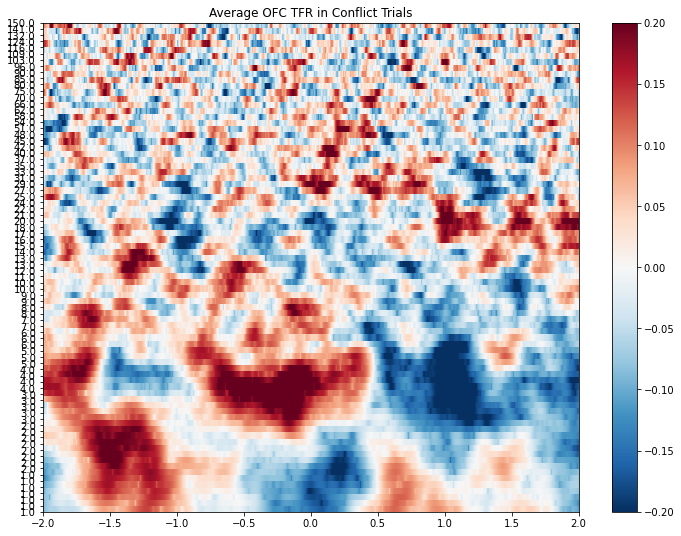

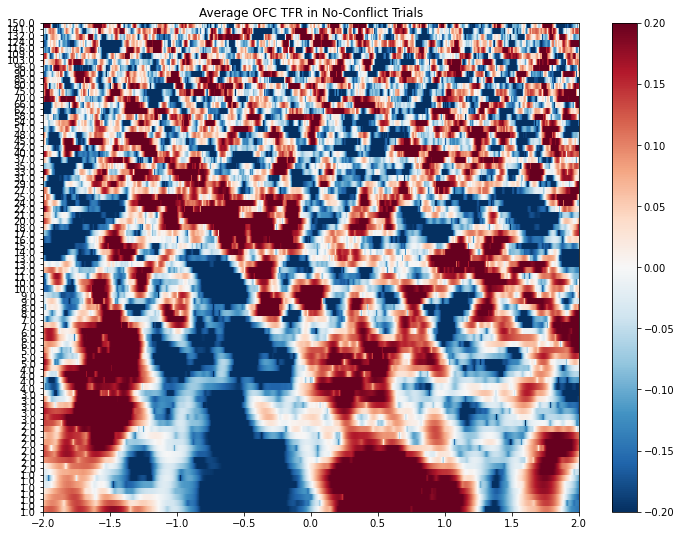

In [30]:
plt.rcParams['figure.figsize'] = [14, 11]
fig, ax = plt.subplots()
i = ax.imshow(ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average OFC TFR in Conflict Trials")
fig.show()


fig, ax = plt.subplots()
i = ax.imshow(no_ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average OFC TFR in No-Conflict Trials")
fig.show()

## Trial Theta

In [19]:
# loop over channels and save csvs
fidx = np.where((freqs > 3) & (freqs < 8))[0]

# Ghost Trials
for chix in range(len(ghost_TFR.ch_names)):

    trial_theta_power = ghost_TFR.data[:, chix, fidx, :].mean(axis = 1)
    channel_df = pd.DataFrame(trial_theta_power[:, ::50])
    channel_df['trial'] = ghost_hc.metadata.trial_numeric.to_numpy(copy = True)
        
    channel_df.to_csv(f"{preproc_data_dir}/theta_csvs/{ghost_TFR.ch_names[chix]}_ofc_trial_theta_choice_locked_ghost.csv")
    
    

# No Ghost Trials
for chix in range(len(no_ghost_TFR.ch_names)):

    trial_theta_power = no_ghost_TFR.data[:, chix, fidx, :].mean(axis = 1)
    channel_df = pd.DataFrame(trial_theta_power[:, ::50])
    channel_df['trial'] = no_ghost_hc.metadata.trial_numeric.to_numpy(copy = True)
        
    channel_df.to_csv(f"{preproc_data_dir}/theta_csvs/{no_ghost_TFR.ch_names[chix]}_ofc_trial_theta_choice_locked_noghost.csv")   

In [31]:
# true difference matrix
true_diff_matrix = ghost_TFR.data[:, :, :, :].mean(axis = 0).mean(axis = 0) - no_ghost_TFR.data[:, :, :, :].mean(axis = 0).mean(axis = 0)


# initialize permuted matrix
permuted_matrix = np.nan * np.ones_like(true_diff_matrix)
permuted_matrices = np.repeat(permuted_matrix[np.newaxis,...], 1000, axis=0)

# get incex vectors
num_ghost_trials = ghost_TFR.data.shape[0]
num_no_ghost_trials = no_ghost_TFR.data.shape[0]
total_trials = num_ghost_trials + num_no_ghost_trials
trial_indices = np.arange(0, total_trials, 1)

# combine all tfrs
all_tfrs = np.concatenate([ghost_TFR.data[:, :, :, :] , no_ghost_TFR.data[:, :, :, :]], axis = 0)

for permute in range(0, 1000):
    
    trial_indices = np.arange(0, total_trials, 1)
    np.random.seed(permute)
    fake_ghost_indices = np.random.choice(a = trial_indices, size=num_ghost_trials, replace = False)
    fake_no_ghost_indicies = np.delete(trial_indices, fake_ghost_indices)


    fake_ghost_tfr = all_tfrs[fake_ghost_indices, :, :, :]
    fake_no_ghost_tfr = all_tfrs[fake_no_ghost_indicies, :, :, :]

    permuted_matrices[permute, :, :] = fake_ghost_tfr.mean(axis = 0).mean(axis = 0) - fake_no_ghost_tfr.mean(axis = 0).mean(axis = 0)


In [32]:
# create dummy sig matrix
sig_matrix = np.full(true_diff_matrix.shape, False, dtype = 'bool')
pval_matrix = np.nan * np.ones_like(true_diff_matrix)


# find values at the extreme
for y in range(0,80):
    for x in range(0, 4001):

        permuted_dist = np.sort(permuted_matrices[:, y, x])

        if true_diff_matrix[y, x] <= permuted_dist[50] or true_diff_matrix[y, x] >=permuted_dist[950] :
            sig_matrix[y, x] = True
        else:
            sig_matrix[y, x] = False

sig_diff_matrix = np.where(sig_matrix, true_diff_matrix, np.nan)


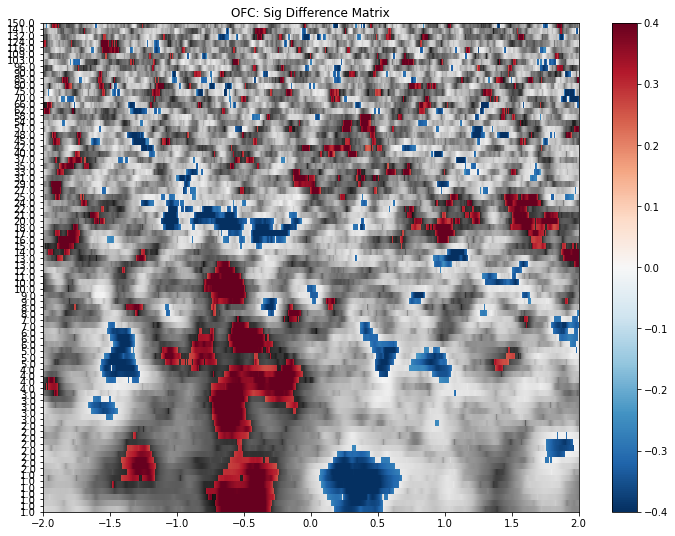

In [33]:

fig, ax = plt.subplots()
i1 = ax.imshow(true_diff_matrix, cmap = 'Greys', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
i2 = ax.imshow(sig_diff_matrix, cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i2)
ax.set_title("OFC: Sig Difference Matrix")
fig.show()



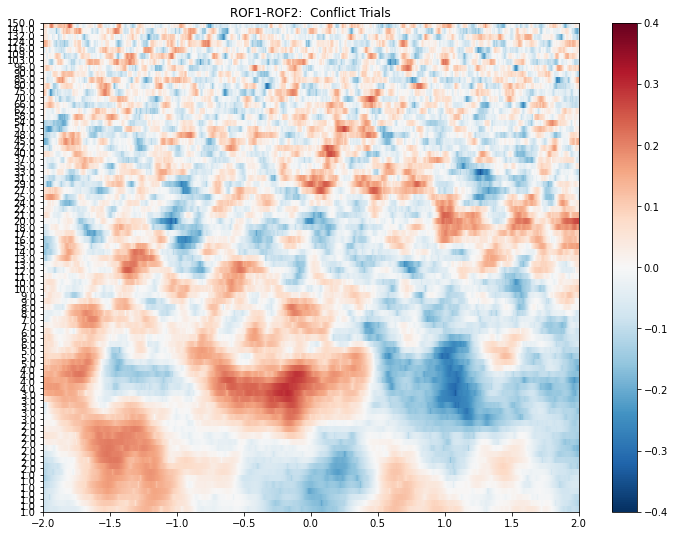

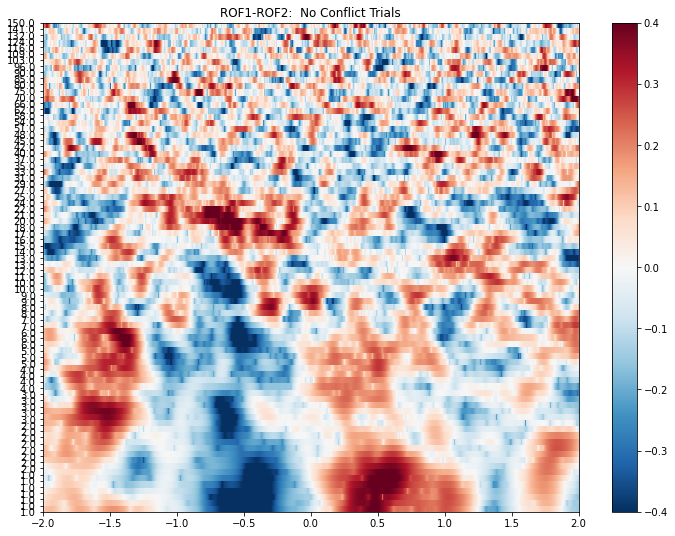

In [34]:
plt.rcParams['figure.figsize'] = [14, 11]

chix = 0
for ch in ghost_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Conflict Trials")
    fig.show()

    fig, ax = plt.subplots()
    i = ax.imshow(no_ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  No Conflict Trials")
    fig.show()
    
    chix = chix + 1

### Amygdala

In [20]:
ghost_hc = ghost_epochs.copy().pick_channels(amyg_list)
no_ghost_hc = no_ghost_epochs.copy().pick_channels(amyg_list)

In [8]:
amyg_list

['RA2-RA3']

In [21]:
ghost_hc= ghost_hc.resample(1000)
no_ghost_hc= no_ghost_hc.resample(1000)

In [22]:
ghost_TFR = []
no_ghost_TFR = []

ghost_TFR = MM_compute_TFR(ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)
no_ghost_TFR = MM_compute_TFR(no_ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)

computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Adding metadata with 5 columns


[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   41.4s finished


log transforming
z-scoring to baseline
computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Adding metadata with 5 columns


[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   10.7s finished


log transforming
z-scoring to baseline


In [23]:
ghost_TFR.crop(tmin = -2, tmax = 2)
no_ghost_TFR.crop(tmin = -2, tmax = 2)

<EpochsTFR | time : [-2.000000, 2.000000], freq : [1.000000, 150.000000], epochs : 41, channels : 1, ~100.1 MB>

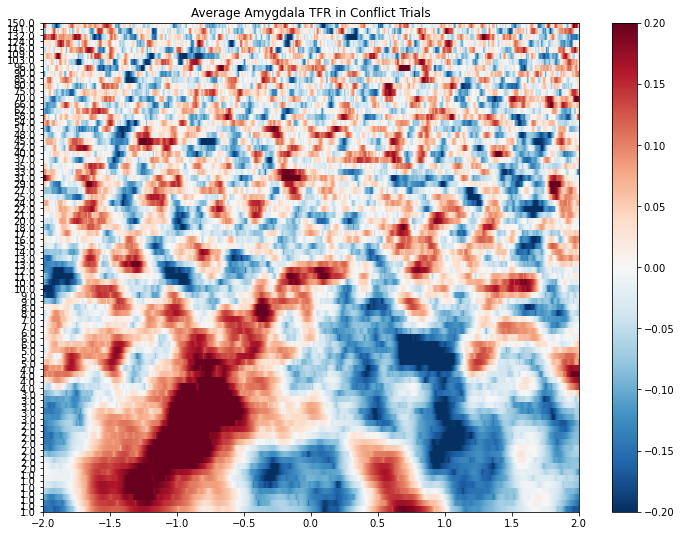

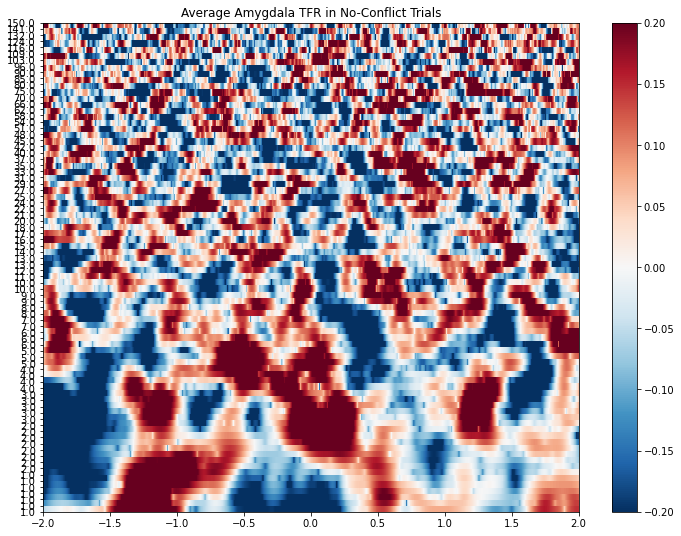

In [39]:
plt.rcParams['figure.figsize'] = [14, 11]
fig, ax = plt.subplots()
i = ax.imshow(ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin =-.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Amygdala TFR in Conflict Trials")
fig.show()


fig, ax = plt.subplots()
i = ax.imshow(no_ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin =-.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Amygdala TFR in No-Conflict Trials")
fig.show()

## Trial Theta

In [24]:
# loop over channels and save csvs
fidx = np.where((freqs > 3) & (freqs < 8))[0]

# Ghost Trials
for chix in range(len(ghost_TFR.ch_names)):

    trial_theta_power = ghost_TFR.data[:, chix, fidx, :].mean(axis = 1)
    channel_df = pd.DataFrame(trial_theta_power[:, ::50])
    channel_df['trial'] = ghost_hc.metadata.trial_numeric.to_numpy(copy = True)
        
    channel_df.to_csv(f"{preproc_data_dir}/theta_csvs/{ghost_TFR.ch_names[chix]}_amyg_trial_theta_choice_locked_ghost.csv")
    
    

# No Ghost Trials
for chix in range(len(no_ghost_TFR.ch_names)):

    trial_theta_power = no_ghost_TFR.data[:, chix, fidx, :].mean(axis = 1)
    channel_df = pd.DataFrame(trial_theta_power[:, ::50])
    channel_df['trial'] = no_ghost_hc.metadata.trial_numeric.to_numpy(copy = True)
        
    channel_df.to_csv(f"{preproc_data_dir}/theta_csvs/{no_ghost_TFR.ch_names[chix]}_amyg_trial_theta_choice_locked_noghost.csv")   

In [40]:
# true difference matrix
true_diff_matrix = ghost_TFR.data[:, :, :, :].mean(axis = 0).mean(axis = 0) - no_ghost_TFR.data[:, :, :, :].mean(axis = 0).mean(axis = 0)


# initialize permuted matrix
permuted_matrix = np.nan * np.ones_like(true_diff_matrix)
permuted_matrices = np.repeat(permuted_matrix[np.newaxis,...], 1000, axis=0)

# get incex vectors
num_ghost_trials = ghost_TFR.data.shape[0]
num_no_ghost_trials = no_ghost_TFR.data.shape[0]
total_trials = num_ghost_trials + num_no_ghost_trials
trial_indices = np.arange(0, total_trials, 1)

# combine all tfrs
all_tfrs = np.concatenate([ghost_TFR.data[:, :, :, :] , no_ghost_TFR.data[:, :, :, :]], axis = 0)

for permute in range(0, 1000):
    
    trial_indices = np.arange(0, total_trials, 1)
    np.random.seed(permute)
    fake_ghost_indices = np.random.choice(a = trial_indices, size=num_ghost_trials, replace = False)
    fake_no_ghost_indicies = np.delete(trial_indices, fake_ghost_indices)


    fake_ghost_tfr = all_tfrs[fake_ghost_indices, :, :, :]
    fake_no_ghost_tfr = all_tfrs[fake_no_ghost_indicies, :, :, :]

    permuted_matrices[permute, :, :] = fake_ghost_tfr.mean(axis = 0).mean(axis = 0) - fake_no_ghost_tfr.mean(axis = 0).mean(axis = 0)


In [41]:
# create dummy sig matrix
sig_matrix = np.full(true_diff_matrix.shape, False, dtype = 'bool')
pval_matrix = np.nan * np.ones_like(true_diff_matrix)


# find values at the extreme
for y in range(0,80):
    for x in range(0, 4001):

        permuted_dist = np.sort(permuted_matrices[:, y, x])

        if true_diff_matrix[y, x] <= permuted_dist[50] or true_diff_matrix[y, x] >=permuted_dist[950] :
            sig_matrix[y, x] = True
        else:
            sig_matrix[y, x] = False

sig_diff_matrix = np.where(sig_matrix, true_diff_matrix, np.nan)


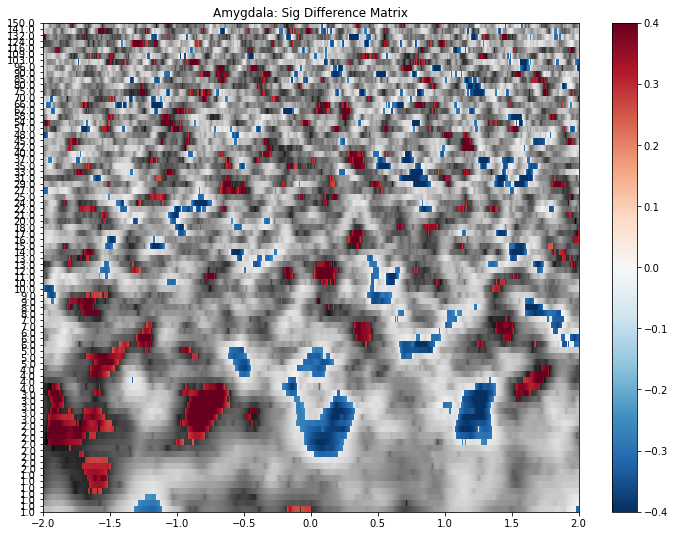

In [42]:

fig, ax = plt.subplots()
i1 = ax.imshow(true_diff_matrix, cmap = 'Greys', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
i2 = ax.imshow(sig_diff_matrix, cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i2)
ax.set_title("Amygdala: Sig Difference Matrix")
fig.show()



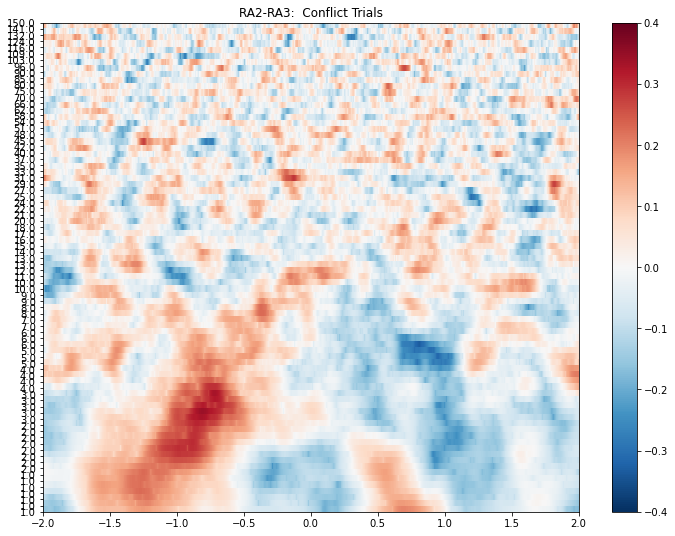

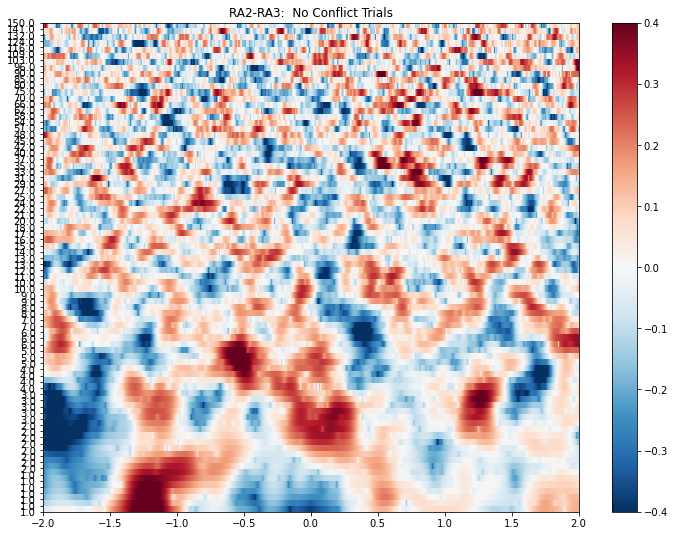

In [43]:
plt.rcParams['figure.figsize'] = [14, 11]

chix = 0
for ch in ghost_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Conflict Trials")
    fig.show()

    fig, ax = plt.subplots()
    i = ax.imshow(no_ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  No Conflict Trials")
    fig.show()
    
    chix = chix + 1

### Cingulate

In [25]:
ghost_hc = ghost_epochs.copy().pick_channels(cing_list)
no_ghost_hc = no_ghost_epochs.copy().pick_channels(cing_list)

In [26]:
ghost_hc= ghost_hc.resample(1000)
no_ghost_hc= no_ghost_hc.resample(1000)

In [27]:
ghost_TFR = []
no_ghost_TFR = []

ghost_TFR = MM_compute_TFR(ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)
no_ghost_TFR = MM_compute_TFR(no_ghost_hc,freqs,n_cycles,baseline = (-2,2), zscore=True)

computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   6 | elapsed:   58.8s remaining:   58.8s
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:  1.0min finished


Adding metadata with 5 columns
log transforming
z-scoring to baseline
computing TFR


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   6 | elapsed:   14.7s remaining:   14.7s
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:   15.7s finished


Adding metadata with 5 columns
log transforming
z-scoring to baseline


In [28]:
ghost_TFR.crop(tmin = -2, tmax = 2)
no_ghost_TFR.crop(tmin = -2, tmax = 2)

<EpochsTFR | time : [-2.000000, 2.000000], freq : [1.000000, 150.000000], epochs : 41, channels : 6, ~600.7 MB>

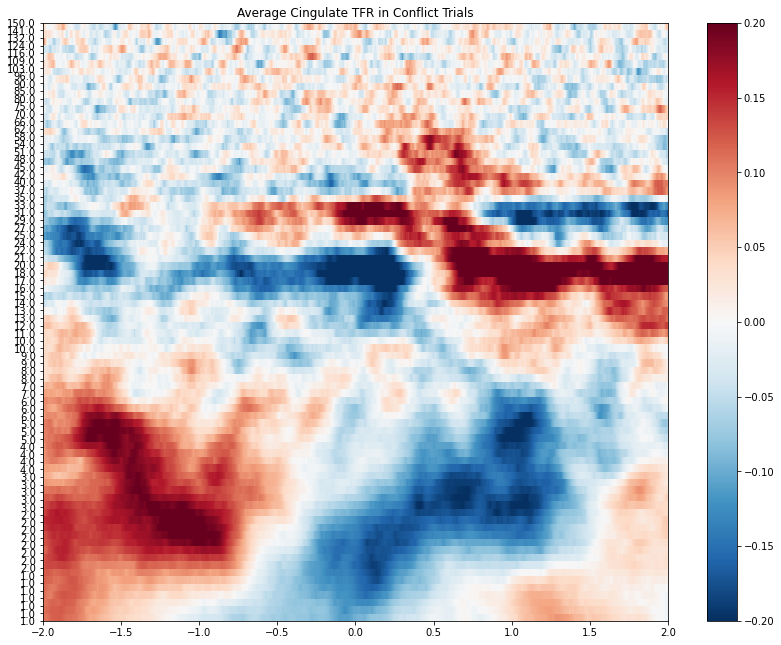

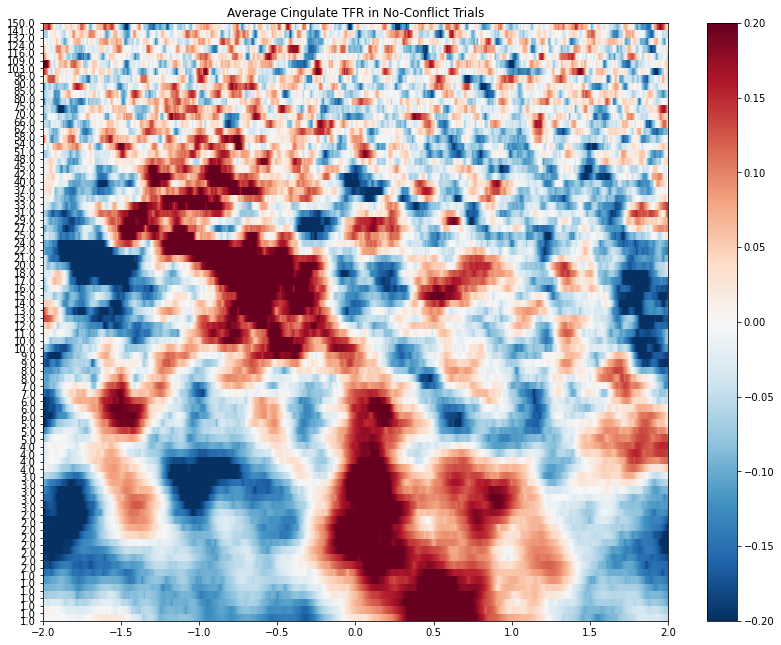

In [21]:
plt.rcParams['figure.figsize'] = [14, 11]
fig, ax = plt.subplots()
i = ax.imshow(ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin =-.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Cingulate TFR in Conflict Trials")
fig.show()
fig.savefig('LL10_average_cingulate_conflict.png', dpi=600)

fig, ax = plt.subplots()
i = ax.imshow(no_ghost_TFR.data.mean(axis = 0).mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin =-.2, vmax = .2)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i)
ax.set_title("Average Cingulate TFR in No-Conflict Trials")
fig.show()
fig.savefig('LL10_average_cingulate_noconflict.png', dpi=600)



## Trial Theta

In [29]:
# loop over channels and save csvs
fidx = np.where((freqs > 3) & (freqs < 8))[0]

# Ghost Trials
for chix in range(len(ghost_TFR.ch_names)):

    trial_theta_power = ghost_TFR.data[:, chix, fidx, :].mean(axis = 1)
    channel_df = pd.DataFrame(trial_theta_power[:, ::50])
    channel_df['trial'] = ghost_hc.metadata.trial_numeric.to_numpy(copy = True)
        
    channel_df.to_csv(f"{preproc_data_dir}/theta_csvs/{ghost_TFR.ch_names[chix]}_cing_trial_theta_choice_locked_ghost.csv")
    
    

# No Ghost Trials
for chix in range(len(no_ghost_TFR.ch_names)):

    trial_theta_power = no_ghost_TFR.data[:, chix, fidx, :].mean(axis = 1)
    channel_df = pd.DataFrame(trial_theta_power[:, ::50])
    channel_df['trial'] = no_ghost_hc.metadata.trial_numeric.to_numpy(copy = True)
        
    channel_df.to_csv(f"{preproc_data_dir}/theta_csvs/{no_ghost_TFR.ch_names[chix]}_cing_trial_theta_choice_locked_noghost.csv")   

In [49]:
# true difference matrix
true_diff_matrix = ghost_TFR.data[:, :, :, :].mean(axis = 0).mean(axis = 0) - no_ghost_TFR.data[:, :, :, :].mean(axis = 0).mean(axis = 0)


# initialize permuted matrix
permuted_matrix = np.nan * np.ones_like(true_diff_matrix)
permuted_matrices = np.repeat(permuted_matrix[np.newaxis,...], 1000, axis=0)

# get incex vectors
num_ghost_trials = ghost_TFR.data.shape[0]
num_no_ghost_trials = no_ghost_TFR.data.shape[0]
total_trials = num_ghost_trials + num_no_ghost_trials
trial_indices = np.arange(0, total_trials, 1)

# combine all tfrs
all_tfrs = np.concatenate([ghost_TFR.data[:, :, :, :] , no_ghost_TFR.data[:, :, :, :]], axis = 0)

for permute in range(0, 1000):
    
    trial_indices = np.arange(0, total_trials, 1)
    np.random.seed(permute)
    fake_ghost_indices = np.random.choice(a = trial_indices, size=num_ghost_trials, replace = False)
    fake_no_ghost_indicies = np.delete(trial_indices, fake_ghost_indices)


    fake_ghost_tfr = all_tfrs[fake_ghost_indices, :, :, :]
    fake_no_ghost_tfr = all_tfrs[fake_no_ghost_indicies, :, :, :]

    permuted_matrices[permute, :, :] = fake_ghost_tfr.mean(axis = 0).mean(axis = 0) - fake_no_ghost_tfr.mean(axis = 0).mean(axis = 0)


In [50]:
# create dummy sig matrix
sig_matrix = np.full(true_diff_matrix.shape, False, dtype = 'bool')
pval_matrix = np.nan * np.ones_like(true_diff_matrix)


# find values at the extreme
for y in range(0,80):
    for x in range(0, 4001):

        permuted_dist = np.sort(permuted_matrices[:, y, x])

        if true_diff_matrix[y, x] <= permuted_dist[50] or true_diff_matrix[y, x] >=permuted_dist[950] :
            sig_matrix[y, x] = True
        else:
            sig_matrix[y, x] = False

sig_diff_matrix = np.where(sig_matrix, true_diff_matrix, np.nan)


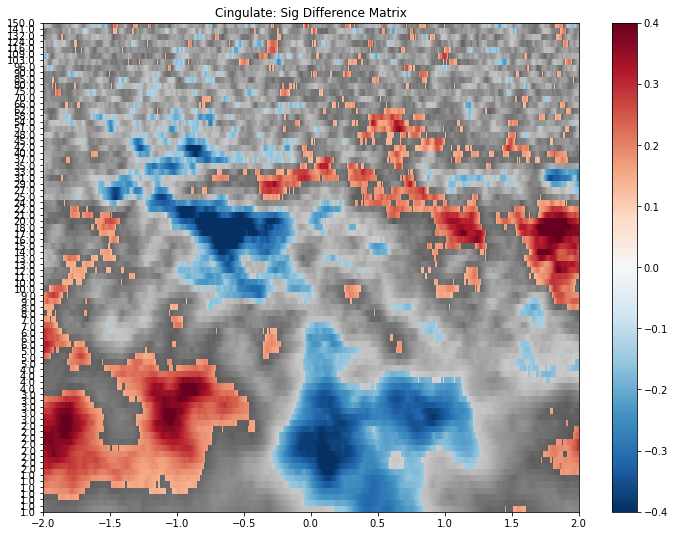

In [51]:

fig, ax = plt.subplots()
i1 = ax.imshow(true_diff_matrix, cmap = 'Greys', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
i2 = ax.imshow(sig_diff_matrix, cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
ax.set_yticklabels(np.round(ghost_TFR.freqs))
bar = plt.colorbar(i2)
ax.set_title("Cingulate: Sig Difference Matrix")
fig.show()



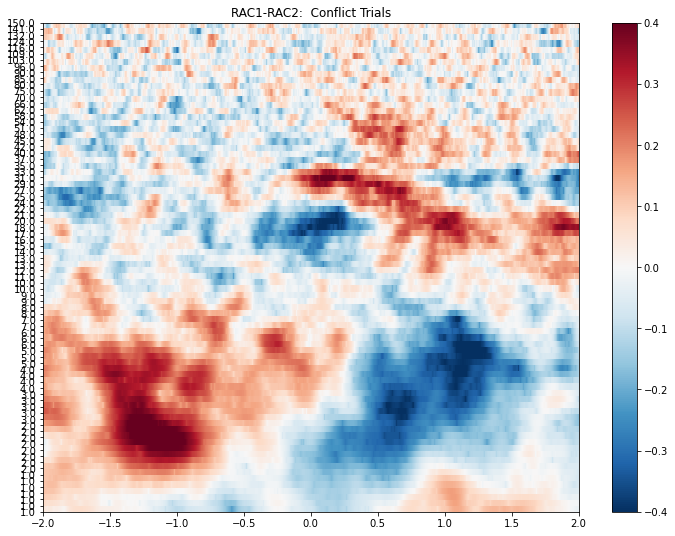

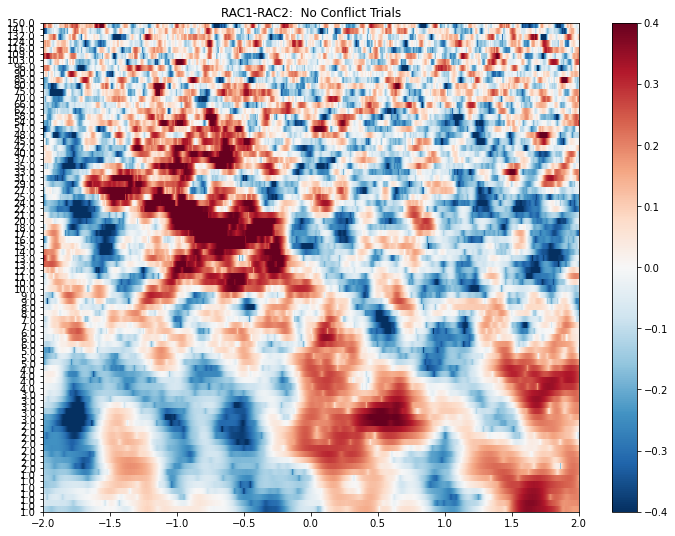

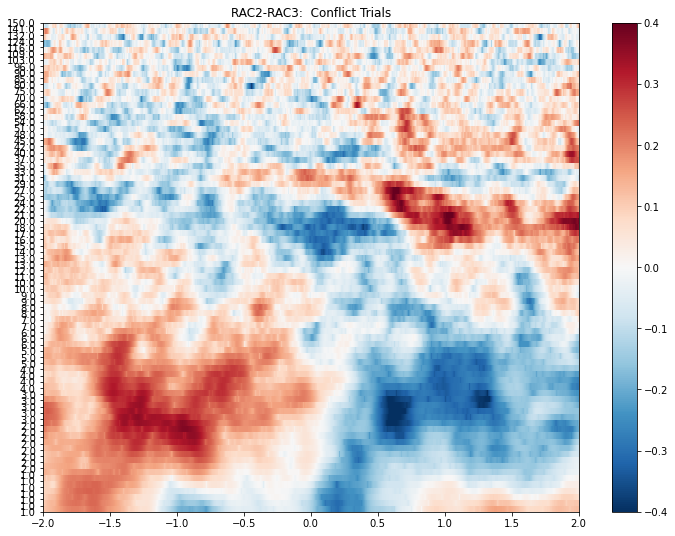

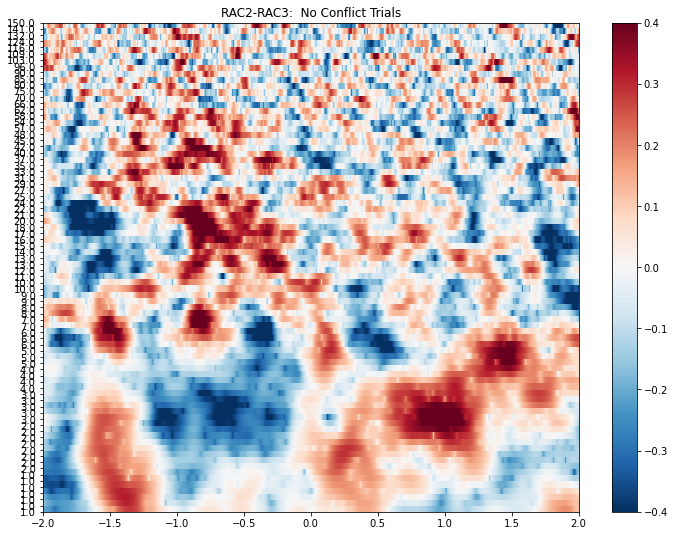

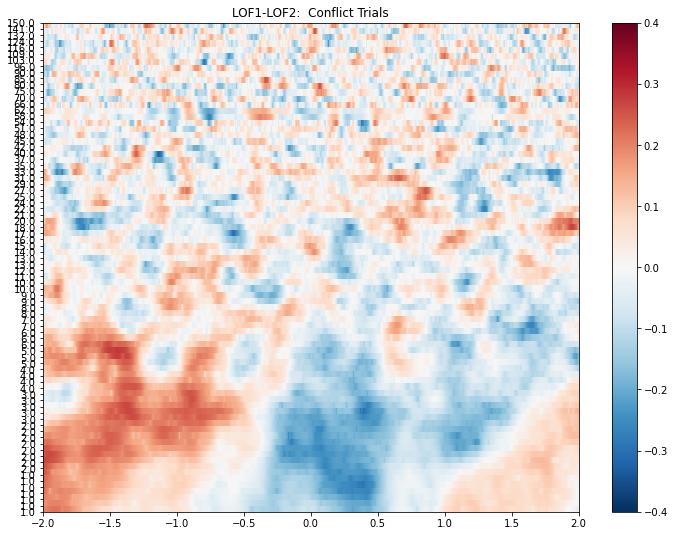

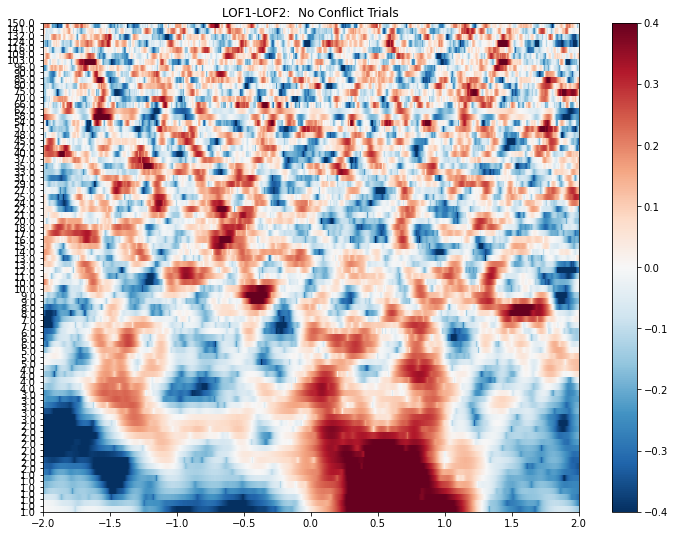

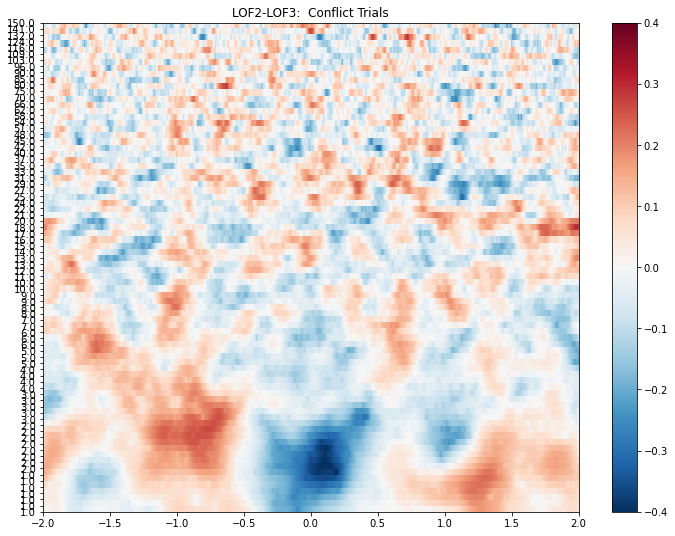

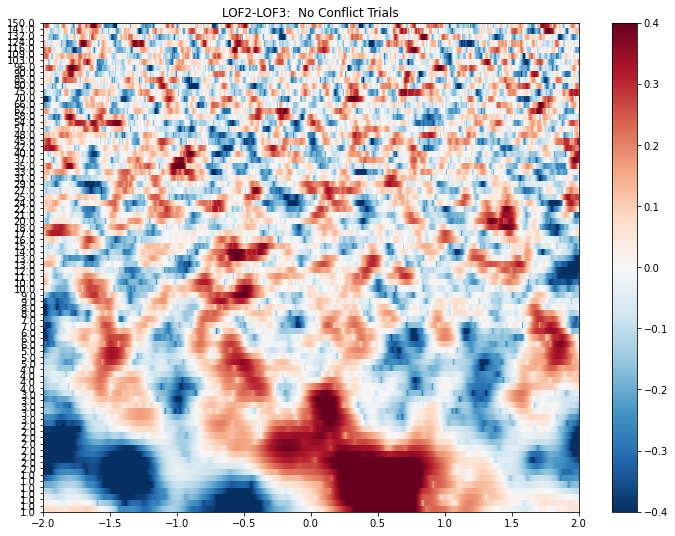

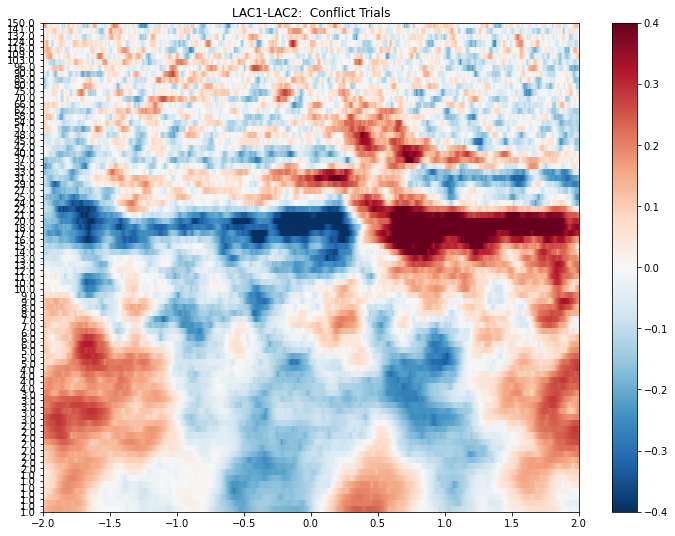

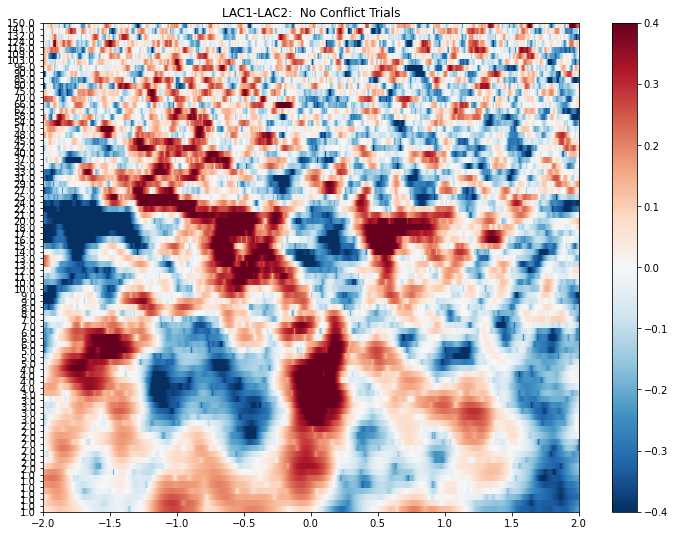

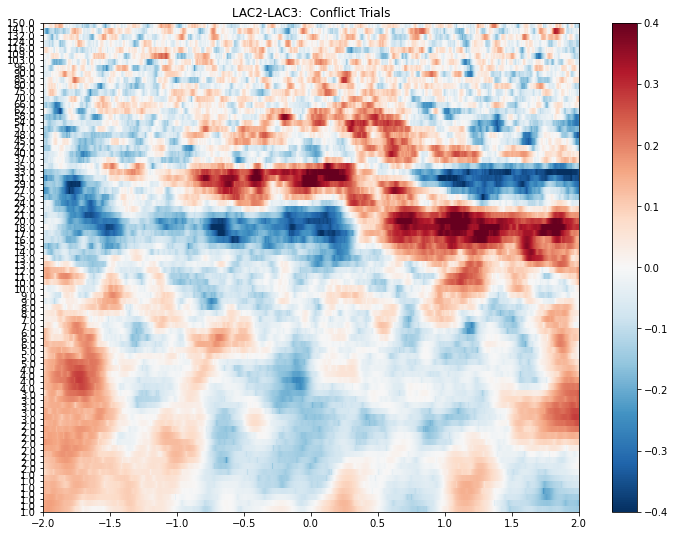

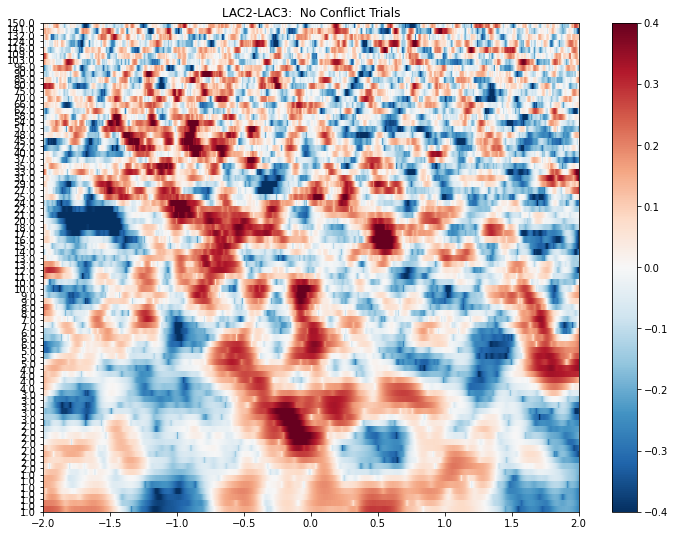

In [52]:
plt.rcParams['figure.figsize'] = [14, 11]

chix = 0
for ch in ghost_TFR.ch_names:

    fig, ax = plt.subplots()
    i = ax.imshow(ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  Conflict Trials")
    fig.show()

    fig, ax = plt.subplots()
    i = ax.imshow(no_ghost_TFR.data[:, chix, :, :].mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -.4, vmax = .4)
    ax.set_yticks(np.linspace(np.min(ghost_TFR.freqs),np.max(ghost_TFR.freqs),len(ghost_TFR.freqs)))
    ax.set_yticklabels(np.round(ghost_TFR.freqs))
    bar = plt.colorbar(i)
    ax.set_title(f"{ch}:  No Conflict Trials")
    fig.show()
    
    chix = chix + 1